# Exploring Datasets

In [2]:
import pandas as pd
df = pd.read_csv('data\myPersonality\mypersonality_final.csv', encoding='latin-1')

In [3]:
import pandas as pd
import pickle
from data_prep import DataPrep
from model import Model
from open_psychometrics import Big5
import matplotlib.pyplot as plt
import datetime

class Predictor():
    def __init__(self):
        self.traits = ['OPN', 'CON', 'EXT', 'AGR', 'NEU']
        self.models = {}
        self.load_models()

    def load_models(self):
        M = Model()
        for trait in self.traits:
            with open('static/' + trait + '_model.pkl', 'rb') as f:
                self.models[trait] = pickle.load(f)

    def predict(self, X, traits='All', predictions='All'):
        predictions = {}
        if traits == 'All':
            for trait in self.traits:
                pkl_model = self.models[trait]

                
                trait_scores = pkl_model.predict(X, regression=True).reshape(1, -1)
                # scaler = MinMaxScaler(feature_range=(0, 50))
                # print(scaler.fit_transform(trait_scores))
                # scaled_trait_scores = scaler.fit_transform(trait_scores)
                predictions['pred_s'+trait] = trait_scores.flatten()[0]
                # predictions['pred_s'+trait] = scaled_trait_scores.flatten()

                trait_categories = pkl_model.predict(X, regression=False)
                predictions['pred_c'+trait] = str(trait_categories[0])
                # predictions['pred_c'+trait] = trait_categories

                trait_categories_probs = pkl_model.predict_proba(X)
                predictions['pred_prob_c'+trait] = trait_categories_probs[:, 1][0]
                # predictions['pred_prob_c'+trait] = trait_categories_probs[:, 1]

        return predictions

    def predict_texts(self, texts):
        outputs = [self.predict([text]) for text in texts]
        return outputs

In [10]:
from tqdm import tqdm
nrows = []
for i,row in tqdm(df.iterrows(), total=len(df)):
    text = row['STATUS'].replace('\n',' ')
    out = p.predict_texts([text])[0]
    nrow = row.to_dict().copy()
    nrow.update(out)
    nrows.append(nrow)

100%|██████████| 9917/9917 [33:39<00:00,  4.91it/s]


In [14]:
df = pd.DataFrame(nrows)

{'OPN': 0.051373321135452524, 'CON': 0.08191370349288746, 'EXT': 0.1072574975209009, 'AGR': 0.06825548531231848, 'NEU': 0.08812927788105901}


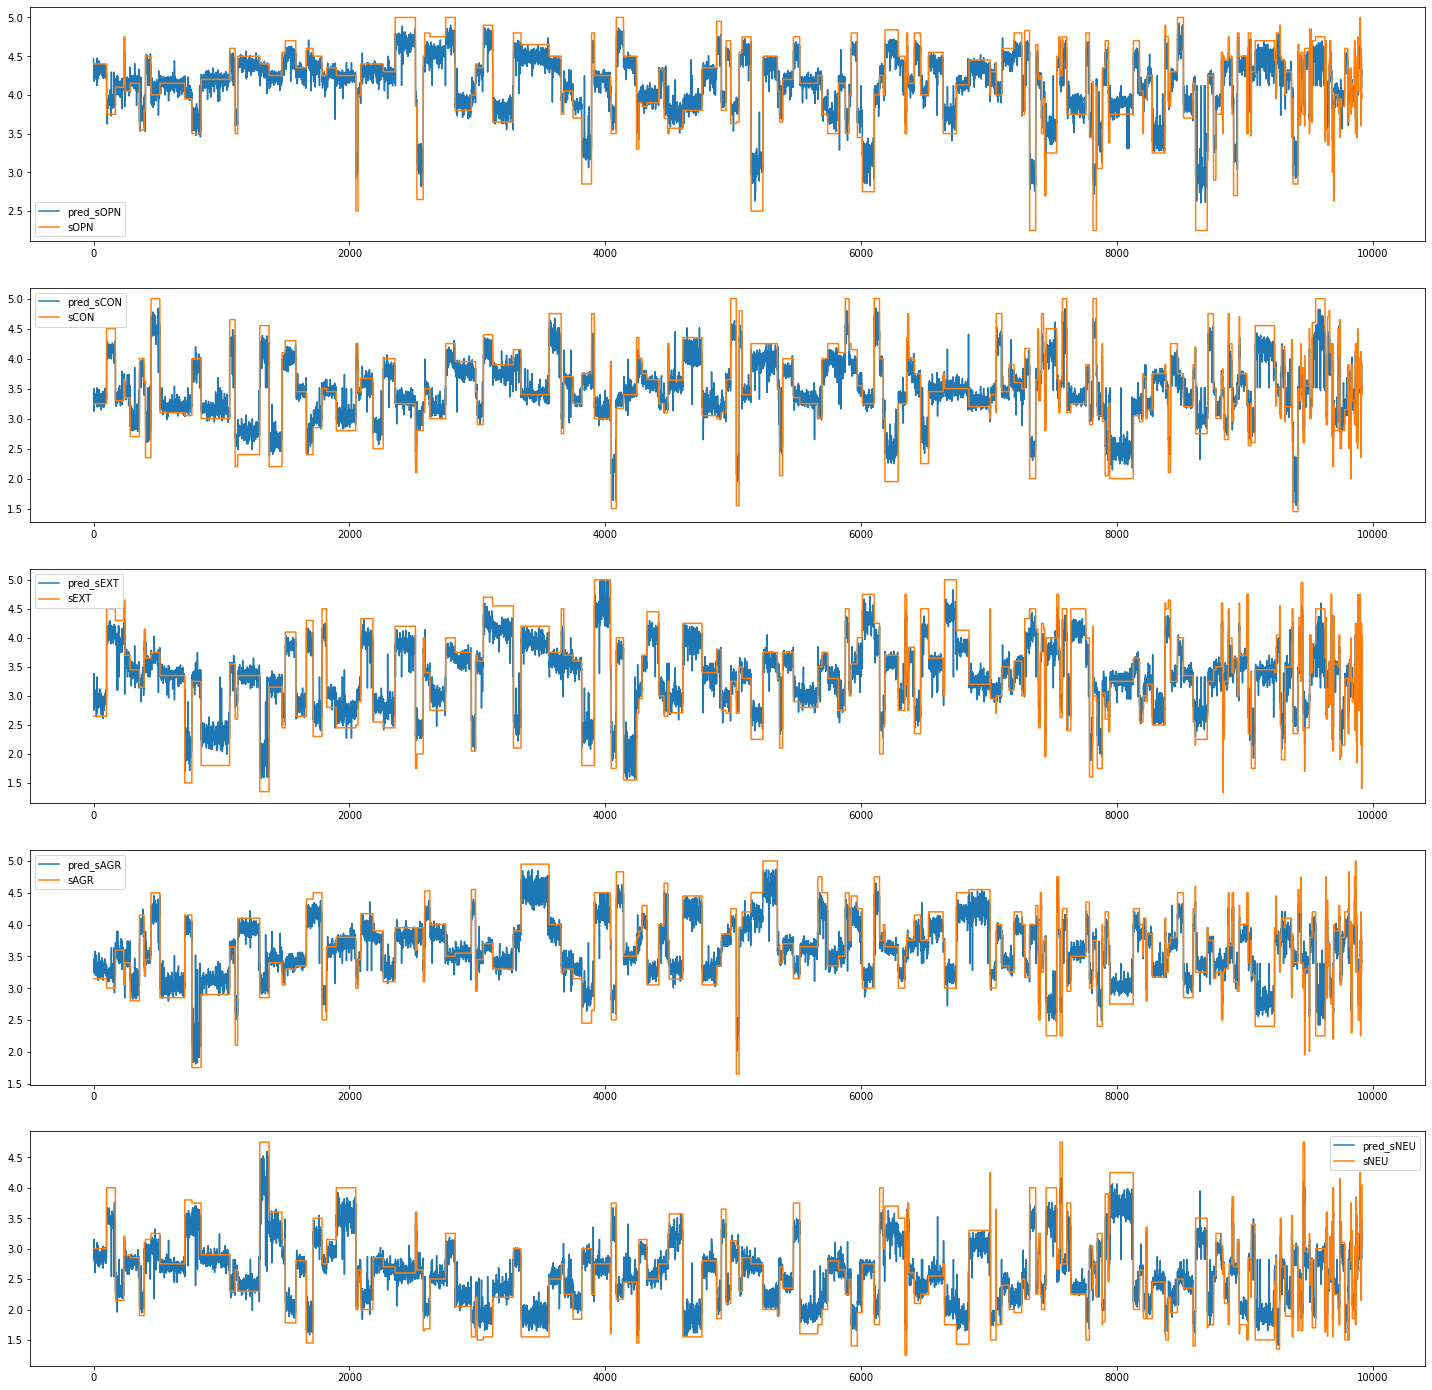

In [33]:
from sklearn.metrics import mean_squared_error
fig,axs = plt.subplots(len(p.traits),1,figsize=(25,25))
errors = {}
for ax,trait in zip(axs,p.traits):
    x = df[[f'pred_s{trait}',f's{trait}']]
    x.plot(ax=ax, legend=True)
    prev = x.iloc[:,0]
    true = x.iloc[:,1]
    errors[trait]=mean_squared_error(true,prev)
print(errors)

In [4]:
import pandas as pd
import os
dataset_path = r'C:\Users\Cristian\Documents\HolisticAI\repos\neural_nets_personality\outputs\organized_text\trait_activating_questions_clean.csv'
df = pd.read_csv((dataset_path))
df.head()

,Unnamed: 0,user,model_name,category,text
0,0,101795738908117305248646918788734152524,gpt2-large,Openness,Learning new information makes me smarter. If ...
1,1,9508329737927247388103444607498302596,gpt2-large,Openness,Learning new information makes me happier as a...
2,2,64709611923285966390384424508504396331,gpt2-large,Openness,Learning new information makes me happy. My do...
3,3,186230264303208085879578740240340291346,gpt2-large,Openness,"Learning new information makes me better."" The..."
4,4,55099189900520783708977247748670530697,gpt2-large,Openness,Learning new information makes me feel as thou...


In [5]:
from tqdm import tqdm
from multiprocessing import Pool
chunk_size = 10
text = df['text'].apply(lambda x: x.replace('\n',' '))
n_chunks = (len(text)+chunk_size-1)//chunk_size

def process(x):
    p = Predictor()
    out = p.predict_texts(x)
    return out

args = []
for i in tqdm(range(n_chunks)):
    start = i*chunk_size
    stop = (i+1)*chunk_size
    gtext = text.iloc[start:stop]
    args.append(gtext)

100%|██████████| 20000/20000 [00:00<00:00, 31151.08it/s]


In [7]:
len(args)

20000

In [9]:
with Pool(processes=8) as p:
    outs = list(tqdm(p.map(process, args), total=len(args)))

In [8]:
from tqdm import tqdm
nrows = []
for i,row in tqdm(df.iterrows(), total=len(df)):
    text = row['text'].replace('\n',' ')
    out = p.predict_texts([text])[0]
    nrow = row.to_dict().copy()
    nrow.update(out)
    nrows.append(nrow)

  0%|          | 0/200000 [00:00<?, ?it/s]


NameError: name 'p' is not defined

In [9]:
pd.DataFrame(nrows).to_excel('prediction.xlsx')

In [10]:
df = pd.DataFrame(nrows)

array([[<AxesSubplot:title={'center':'pred_sNEU'}>]], dtype=object)

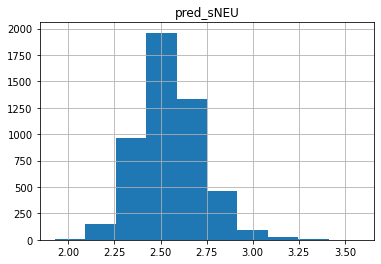

In [36]:
gdf[gdf['category']==cat][['pred_s'+trait]].hist()

In [ ]:
#gdf[gdf['category']=='Openness'][['pred_sOPN','pred_cOPN','pred_prob_cOPN']]
import matplotlib.pyplot as plt
traits = ['OPN', 'CON', 'EXT', 'AGR', 'NEU']
categories = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Emotional stability']

for g,gdf in df.groupby('model_name'):
    plt.figure(figsize=(10,20))

    for i,(cat,trait) in enumerate(zip(categories, traits)):
        print(cat,trait)
        plt.subplot(len(categories),1,i+1)
        x = gdf[gdf['category']==cat]['pred_s'+trait].values
        if trait=='NEU':
            x = 5-x
        plt.hist(x)
        plt.title(cat)
        plt.xlim([1,5])
    plt.savefig(f'{g}.jpg')

In [44]:
import json
json_path = r"C:\Users\cris_\Documents\GitHub\neural_nets_personality\data\trait_activating_questions.json"
with open(json_path) as file:
    data = json.load(file)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

traits = ['OPN', 'CON', 'EXT', 'AGR', 'NEU']
categories = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Emotional stability']

for g,gdf in df.groupby('model_name'):
    #plt.figure(figsize=(10,20))

    fig, axs = plt.subplots(5,1, sharex=False, sharey=False, figsize=(15,20), frameon=False)
    fig.subplots_adjust(left=0.25)
    for i,(cat,trait) in enumerate(zip(categories, traits)):
        
        starting_texts = data[cat] 
        cdf = gdf[gdf['category']==cat]

        scores = []
        for stext in starting_texts:
            mask = cdf['text'].apply(lambda x:x.startswith(stext))
            x = cdf[mask]['pred_s' + trait].values
            if trait=='NEU':
                x = 5-x
            scores.append(np.mean(x))
        axs[i].barh(starting_texts, scores)

        axs[i].set_title(cat)

        axs[i].invert_yaxis()

        axs[i].set_xlim([1,5])

    plt.savefig(f'text_{g}.jpg')

In [ ]:
df = pd.read_excel('prediction.xlsx')

gpt2
[4.19755834377398, 3.5235664671435902, 3.3036778987481026, 3.560033069895793, 2.4505017219819143]
gpt2_medium
[4.1925426146245774, 3.517059102647406, 3.291499637342075, 3.560561207417735, 2.4470672838225815]
gpt2_large
[4.1864157927586785, 3.5235777969134374, 3.308351906961159, 3.55933434712842, 2.449278732172555]
op_125m
[4.234038329161221, 3.4529643957309197, 3.2264041563302848, 3.554627116896911, 2.2335562937713678]
op_350m
[4.188376084969132, 3.483968154684168, 3.2991367984707116, 3.575183831714529, 2.408114797147785]
op_13b
[4.188138030694013, 3.471886110105693, 3.2427139047706883, 3.5308631462254505, 2.369403502783386]
xlnet
[4.308750025650016, 3.4911161698086284, 3.1966223258011293, 3.55603672766058, 2.2052162666940758]
xlnet_large
[4.30298546274705, 3.4790105588470586, 3.201812954311435, 3.5638240714413274, 2.2075162763101868]


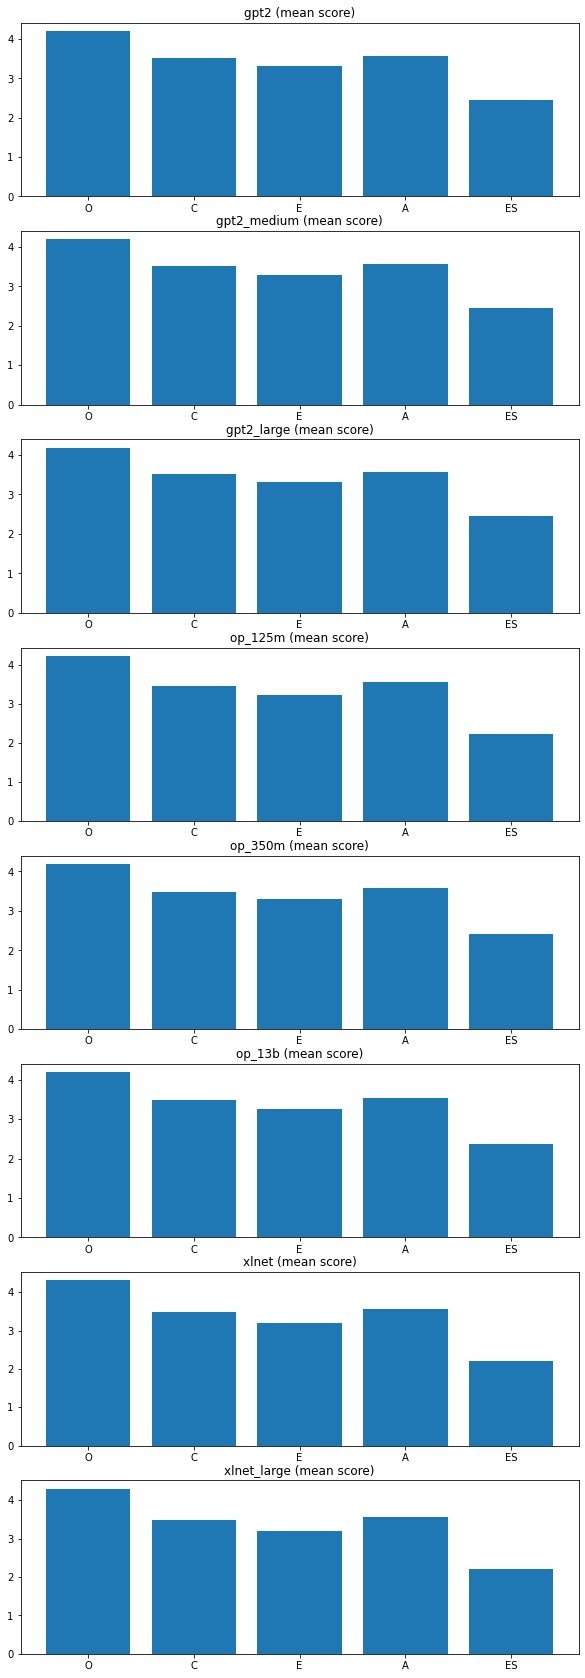

In [101]:
import matplotlib.pyplot as plt
traits = ['OPN', 'CON', 'EXT', 'AGR', 'NEU']
categories = ['Openness', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Emotional stability']
model_names = ['gpt2','gpt2_medium','gpt2_large','op_125m','op_350m','op_13b', 'xlnet', 'xlnet_large']
names = list(map(lambda x:x[0],traits))
names[-1]='ES'
plt.figure(figsize=(10,30))

for k,g in enumerate(model_names):
    gdf=df[df['model_name']==g]
    print(g)
    plt.subplot(8,1,k+1)
    #fig.subplots_adjust(top=3.25)
    xvalues = []
    for i,(cat,trait) in enumerate(zip(categories, traits)):
        #print(cat,trait)
        x = gdf[gdf['category']==cat]['pred_s'+trait].values
        if trait=='NEU':
            x = 5-x
        xvalues.append(np.mean(x))
    
    plt.bar(names,xvalues)
    print(xvalues)
    plt.title(f'{g} (mean score)')
    #plt.xlim([1,5])
plt.savefig(f'personality.jpg')

In [63]:
mdf = pd.read_csv('data/myPersonality/mypersonality_final.csv', encoding='latin-1')
#mdf.head()

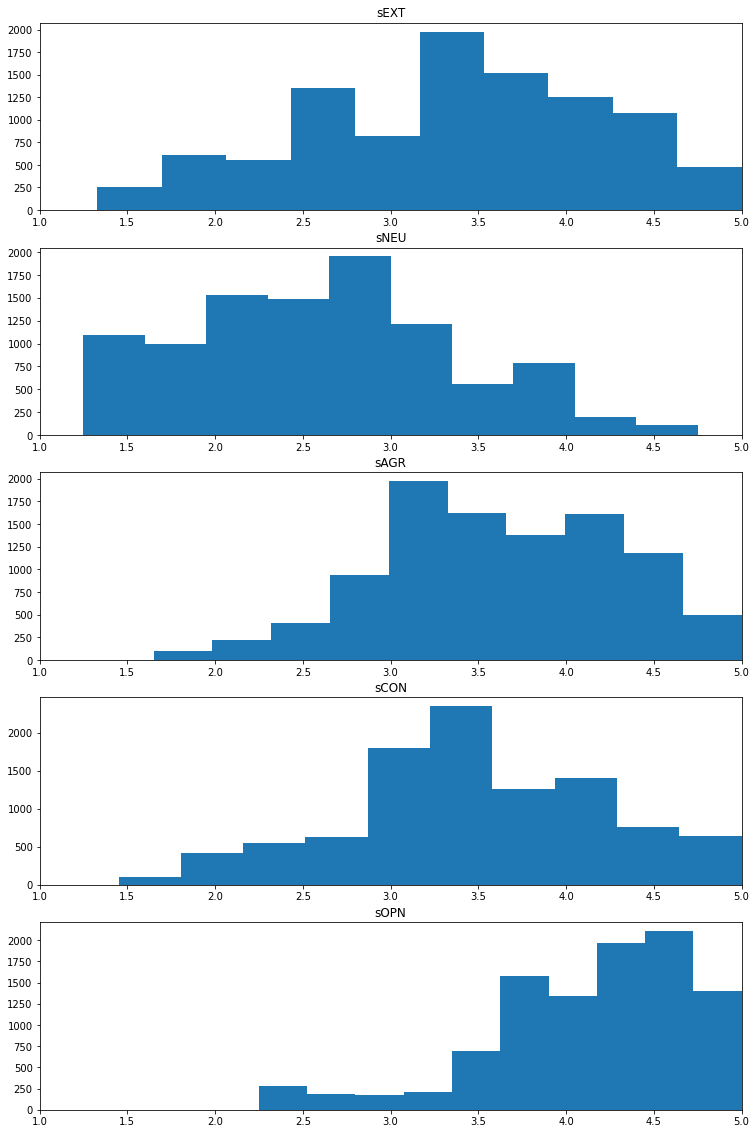

In [72]:
cats = ['sEXT',	'sNEU',	'sAGR',	'sCON',	'sOPN']
fig, axs = plt.subplots(5,1, sharex=False, sharey=False, figsize=(15,20), frameon=False)
fig.subplots_adjust(left=0.25)
for i,c in enumerate(cats):
    values = mdf[c].values
    axs[i].hist(values)
    axs[i].set_xlim([1,5])
    axs[i].set_title(c)
plt.savefig(f'dataset_{c}.jpg')